In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import eli5

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as metrics

# Functions

In [2]:
# Définition d'une fonction permettant d'afficher la matrice de confusion et l'accuracy
def plot_confusion_matrix(y_true, y_pred, labels = [0, 1]):
    #Calculate accuracy and confusion matrix
    accuracy = metrics.accuracy_score(y_true, y_pred)
    cm = metrics.confusion_matrix(y_true, y_pred, labels = labels)
    
    #Plot confusion matrix
    plt.figure(figsize=(7,7))
    ax = sns.heatmap(cm, annot= True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', 
               xticklabels = labels, yticklabels = labels);
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.1, top - 0.1)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {:.3f}'.format(accuracy)
    plt.title(all_sample_title, size = 15);
    return 

# Load data

In [3]:
# Read csv and create list of tags 
df = pd.read_csv('in/StackOverflow_600_posts.csv')
df = df[['Id', 'Title', 'Body', 'Tags']]

df['Post'] = df['Title'] + ' ' + df['Body']
df.drop(columns = ['Title', 'Body'], inplace = True)

df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')
df['nTags'] = df['Tags'].apply(len)

n_posts = df['Id'].count()

In [4]:
# Create tags matrix of size n_obs * n_tags
mlb = MultiLabelBinarizer(sparse_output = False)
df_tags = pd.DataFrame(mlb.fit_transform(df['Tags']), columns = mlb.classes_, index = df.index)

# Analyze tags

In [5]:
# Sort df_tags per number of occurences 
df_tags_unique = pd.DataFrame(df_tags.sum(axis = 0).sort_values(ascending = False), columns = ['n_occurence'])
df_tags = df_tags[df_tags_unique.index]

In [6]:
# Calculate cumulative percentage of tags
n_total_tags = df_tags.sum().sum()
df_tags_unique['pct_tags'] = df_tags_unique.cumsum(axis = 0) / n_total_tags * 100

In [7]:
# Calculate what % of posts are covered by at least one tag 
df_tmp = pd.DataFrame(index = df_tags.index, columns = ['Tagged'])
df_tmp['Tagged'] = 0

for col in df_tags:
    df_tmp['Tagged'] = df_tmp['Tagged'] | df_tags[col]
    df_tags_unique.loc[col, 'n_posts'] = df_tmp['Tagged'].sum()
    
df_tags_unique['pct_posts'] = df_tags_unique['n_posts'] / n_posts * 100

# Reset index to create tag col
df_tags_unique = df_tags_unique.reset_index().rename(columns = {'index': 'tag'})

n_tags_unique = df_tags_unique['tag'].count()
n_tags_unique

707

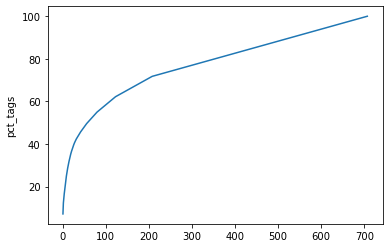

In [8]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_tags'])

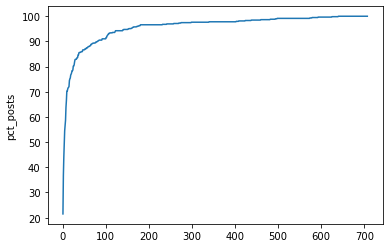

In [9]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_posts'])

# Modelling

## Select subset of tags to create train and test set

In [10]:
list_top = df_tags_unique.loc[0:19, 'tag']

df_tags = df_tags[list_top]

keep_index = df_tags[df_tags.sum(axis = 1) != 0].index

X = df.loc[keep_index, 'Post']
y = df_tags.loc[keep_index, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Create pipeline

In [11]:
# clf = BinaryRelevance(classifier = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3, random_state = 42,
#                                                  max_iter = 5, tol = None), 
#                       require_dense = [True, True])

clf = BinaryRelevance(classifier = RandomForestClassifier(n_estimators = 100), require_dense = [True, True])

ml_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')), 
                   ('tfidf', TfidfTransformer()), 
                   ('clf', clf)])

In [12]:
ml_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                 BinaryRelevance(classifier=RandomForestClassifier(bootstrap=True,
                                                                   class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=None,

# Mesure model performance

In [13]:
y_pred = ml_clf.predict(X_test)
y_pred = pd.DataFrame(y_pred.toarray(), columns = y_test.columns, index = y_test.index)

In [14]:
pd.DataFrame(metrics.jaccard_score(y_test, y_pred, average = None), index = y_test.columns, columns = ['jaccard'])

,jaccard
python,0.372093
javascript,0.259259
java,0.111111
r,0.000000
c,0.250000
html,0.000000
reactjs,0.000000
c#,0.000000
php,0.000000
c++,0.000000


In [15]:
y_proba = ml_clf.predict_proba(X_test)
y_proba = pd.DataFrame(y_proba.toarray(), columns = y_test.columns, index = y_test.index)

In [16]:
y_proba

,python,javascript,java,r,c,html,reactjs,c#,php,c++,arrays,python-3.x,css,pandas,jquery,sql,django,mysql,typescript,json
452,0.68,0.04,0.06,0.06,0.11,0.01,0.04,0.03,0.00,0.08,0.00,0.08,0.01,0.05,0.00,0.02,0.01,0.02,0.01,0.01
79,0.07,0.65,0.06,0.05,0.03,0.03,0.27,0.13,0.04,0.02,0.12,0.04,0.01,0.00,0.01,0.02,0.03,0.01,0.03,0.01
382,0.15,0.10,0.03,0.36,0.04,0.02,0.02,0.02,0.04,0.06,0.03,0.00,0.00,0.04,0.00,0.09,0.03,0.08,0.01,0.01
533,0.12,0.58,0.03,0.03,0.01,0.11,0.01,0.03,0.06,0.00,0.02,0.01,0.03,0.01,0.03,0.02,0.00,0.06,0.00,0.03
152,0.52,0.14,0.12,0.17,0.02,0.12,0.02,0.02,0.03,0.04,0.08,0.11,0.03,0.04,0.02,0.01,0.06,0.01,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.21,0.17,0.06,0.30,0.06,0.10,0.10,0.05,0.03,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.03,0.01,0.00,0.00
549,0.40,0.10,0.10,0.01,0.09,0.01,0.01,0.03,0.00,0.11,0.00,0.08,0.00,0.00,0.01,0.01,0.02,0.00,0.02,0.00
558,0.46,0.06,0.09,0.03,0.04,0.02,0.02,0.02,0.01,0.01,0.11,0.00,0.01,0.04,0.00,0.00,0.02,0.00,0.00,0.06
462,0.14,0.07,0.38,0.08,0.06,0.04,0.01,0.05,0.02,0.03,0.02,0.02,0.00,0.01,0.04,0.00,0.10,0.00,0.00,0.03


In [17]:
for i in np.arange(0, 10, 1):
    decision_threshold = i / 10
    print(decision_threshold, metrics.jaccard_score(y_test, y_proba > decision_threshold, average = 'samples'))

0.0 0.08897857777374625
0.1 0.40152937087243656
0.2 0.46897810218978103
0.3 0.3886861313868613
0.4 0.285279805352798
0.5 0.152676399026764
0.6 0.08819951338199512
0.7 0.021897810218978103
0.8 0.0
0.9 0.0
